<div class="alert alert-block alert-info">

## Проект по А/B-тестированию   

#### Задание: провести оценку результатов A/B-теста. 
Оценить корректность проведения теста.
Проанализировать результаты теста.
    
Чтобы оценить корректность проведения теста, проверим:
- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.   
    
</div>

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Оглавление:  <a id="run"></a>  
</div>

1. [Шаг 1](#step1) Загрузка данных, изучение общей информации и предобработка. 
2. [Шаг 2](#step2) Исследовательский анализ данных.
3. [Шаг 3](#step3) Оценка результатов А/В-тестирования.
4. [Шаг 4](#step4) Общие выводы.

Произведем импортирование библиотек.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

In [2]:
import warnings
warnings.filterwarnings('ignore')

### [Шаг 1.](#run) Загрузка данных, изучение общей информации и предобработка. <a id="step1"></a>   
</div>  

Загрузим календарь маркетинговых событий на 2020 год по всем нужным регионам.
#### Структура файла:
    name — название маркетингового события;
    regions — регионы, в которых будет проводиться рекламная кампания;
    start_dt — дата начала кампании;
    finish_dt — дата завершения кампании.

In [3]:
ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


И сразу приведем данные с датой к нужному типу данных(to_datetime()).

In [4]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'], format='%Y-%m-%d')
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'], format='%Y-%m-%d')

Мы визуально видим, что эта таблица уже готова к дальнейшей работе.

Загрузим информацию о всех пользователях, зарегистрировавшихся в интернет-магазине в период с 7 по 21 декабря 2020 года.
#### Структура файла:
    user_id — идентификатор пользователя;
    first_date — дата регистрации;
    region — регион пользователя;
    device — устройство, с которого происходила регистрация.

In [5]:
final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


И преобразуем дату в нужный тип данных.

In [7]:
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'], format='%Y-%m-%d')

Мы видим, что в данной таблице нет пропусков, поэтому проверим ее только на дубликаты.

In [8]:
final_ab_new_users.duplicated().sum()

0

Дубликаты так же отсутсвуют. Таблица готова к дальнейшей работе.

Загрузим информацию о всех событиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
#### Структура файла:
    user_id — идентификатор пользователя;
    event_dt — дата и время события;
    event_name — тип события;
    details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

In [9]:
final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [10]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


И преобразуем дату в нужный тип данных.

In [11]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'], format='%Y-%m-%d %H:%M:%S')
final_ab_events['event_date'] = final_ab_events['event_dt'].dt.strftime('%Y-%m-%d')

Проверим на дубликаты.

In [12]:
final_ab_events.duplicated().sum()

0

Дубликатов нет. Колонка details заполнена только для события типа purchase и там содержится информация о стоимости, а остальные значения в этом столбце не нужны.

Загрузим информацию об участниках тестов.
#### Структура файла:
    user_id — идентификатор пользователя;
    ab_test — название теста;
    group — группа пользователя.

In [13]:
final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [14]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


In [15]:
final_ab_participants.duplicated().sum()

0

В таблице с участниками АВ-теста нет дубликатов. 
Предобработка данных закончена можно приступать к исследовательскому анализу данных.

Создадим объединенную таблицу с информацией о всех новых пользователях, зарегистрированных в промежуток, когда работал тест.

In [16]:
users = final_ab_events.merge(final_ab_new_users, on='user_id', how='left')
users = users.merge(final_ab_participants, on='user_id', how='left')
users.head()

,user_id,event_dt,event_name,details,event_date,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,2020-12-07,N.America,iPhone,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020-12-07,EU,iPhone,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,2020-12-07,N.America,iPhone,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020-12-07,EU,iPhone,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,2020-12-07,EU,Android,NaN,NaN


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446211 entries, 0 to 446210
Data columns (total 10 columns):
user_id       446211 non-null object
event_dt      446211 non-null datetime64[ns]
event_name    446211 non-null object
details       63588 non-null float64
event_date    446211 non-null object
first_date    446211 non-null datetime64[ns]
region        446211 non-null object
device        446211 non-null object
group         106625 non-null object
ab_test       106625 non-null object
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 37.4+ MB


Посмотрим появились ли дубликаты в объединенной таблице.

In [18]:
users.duplicated().sum()

0

Мы видим, что действий пользователей, зарегистрировавшихся в необходимый нам период было 440317. После того, как мы объединили таблицы с информацией о действиях новых пользователях и тестировании получилось информации о 446211 пользователях.

Исходя из этого, можно сделать несколько выводов:
-  В исходных данных содержится информация примерно о 6000 событий, тех пользователей, которые пришли раньше, чем выбранный нами промежуток для новых пользователей;
- Из 446211 действий только 106625 действий относятся к необходимым нам тестам.

### [Шаг 2.](#run) Исследовательский анализ данных. <a id="step2"></a>   
</div> 

#### Проведем анализ конверсии воронки на разных этапах.

Создадим отдельный датафрейм с интересующим нас тестом, а затем поделим на выборки по группам.

In [19]:
ab_test = users.query('ab_test == "recommender_system_test"')
ab_test_A = ab_test.query('group == "A"')
ab_test_B = ab_test.query('group == "B"')
ab_test.head()

,user_id,event_dt,event_name,details,event_date,first_date,region,device,group,ab_test
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,2020-12-07,EU,iPhone,B,recommender_system_test
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,2020-12-07,EU,PC,A,recommender_system_test
75,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,2020-12-07,EU,PC,B,recommender_system_test


Посмотрим сколько всего уникальных пользователей у нас присутствует в тестах.

In [20]:
unique_usersA = ab_test_A['user_id'].nunique()
print(unique_usersA)
unique_usersB = ab_test_B['user_id'].nunique()
print(unique_usersB)

2747
928


По разделению выборки составили соотношение 1 к 3.

И сколько всего уникальных пользователей приняло участие в тестировании.

In [21]:
unique_users = ab_test['user_id'].nunique()
unique_users

3675

В техническом задании было написано, что ожидаемых участников тестирования 6000. А значит произошел недобор.

Создадим таблицу, в которой будет информация о количестве всех пользователей теста, уникальных пользователей и какую долю от всего количества уникальных пользователей занимают уникальные пользователи на каждом этапе для каждой группы.

In [22]:
A_funnel = ab_test_A.groupby('event_name').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).reset_index()
A_funnel2 = ab_test_A.groupby('event_name').agg({'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
A_funnel = A_funnel.merge(A_funnel2, on='event_name', how='left')
A_funnel.columns = ['event_name', 'count_usersA', 'unique_usersA']
A_funnel['part_A'] = A_funnel['unique_usersA'] / unique_usersA
B_funnel = ab_test_B.groupby('event_name').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).reset_index()
B_funnel2 = ab_test_B.groupby('event_name').agg({'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
B_funnel = B_funnel.merge(B_funnel2, on='event_name', how='left')
B_funnel.columns = ['event_name', 'count_usersB', 'unique_usersB']
B_funnel['part_B'] = B_funnel['unique_usersB'] / unique_usersB
funnel = A_funnel.merge(B_funnel, on='event_name', how='left')
funnel

,event_name,count_usersA,unique_usersA,part_A,count_usersB,unique_usersB,part_B
0,login,8566,2747,1.000000,2624,928,1.000000
1,product_page,5525,1780,0.647980,1405,523,0.563578
2,purchase,2655,872,0.317437,676,256,0.275862
3,product_cart,2558,824,0.299964,689,255,0.274784


Добавим столбцы с конверсией.

In [23]:
funnel2 = funnel.copy(deep=True)
funnel2['unique_usersA2'] = funnel2['unique_usersA'].shift()
funnel2['unique_usersB2'] = funnel2['unique_usersB'].shift()

In [24]:
funnel2['convA'] = funnel2['unique_usersA'] / funnel2['unique_usersA2']
funnel2['convB'] = funnel2['unique_usersB'] / funnel2['unique_usersB2']
funnel2 = funnel2.fillna(1)

In [25]:
funnel['convA'] = funnel2['convA']
funnel['convB'] = funnel2['convB']
funnel

,event_name,count_usersA,unique_usersA,part_A,count_usersB,unique_usersB,part_B,convA,convB
0,login,8566,2747,1.000000,2624,928,1.000000,1.000000,1.000000
1,product_page,5525,1780,0.647980,1405,523,0.563578,0.647980,0.563578
2,purchase,2655,872,0.317437,676,256,0.275862,0.489888,0.489484
3,product_cart,2558,824,0.299964,689,255,0.274784,0.944954,0.996094


Мы видим, что доля пользователей, которая проходит на следующий этап выше в контрольной группе А, чем в экспериментальной группе В.

#### Обладают ли выборки одинаковыми распределениями количества событий на пользователя?

Посмотрим по каждой выборке, сколько в среднем приходится событий на одного пользователя.

In [26]:
event_per_userA = ab_test_A.groupby('user_id').agg({'event_name' : 'count'}).sort_values(by='user_id', ascending=False).reset_index()
event_per_userA['event_name'].mean()

7.027302511831088

In [27]:
event_per_userB = ab_test_B.groupby('user_id').agg({'event_name' : 'count'}).sort_values(by='user_id', ascending=False).reset_index()
event_per_userB['event_name'].mean()

5.8125

Мы видим, что в контрольной группе на одного пользователя приходится в среднем на 1,2 действия больше, чем в экспериментальной. Это может быть связано с тем, что в контрольно в три раза больше выборка и из-за этого может быть больше выбросов.

#### Присутствуют ли в выборках одни и те же пользователи?

Создадим отдельный дф, в котором будут только id пользователей. Необходимо будет сравнить два столбца на предмет совпадений.

In [28]:
event_per_user = event_per_userA.copy(deep=True)
event_per_user.columns = ['user_id_A', 'count_user_A']
event_per_user['user_id_B'] = event_per_userB['user_id']
event_per_user[['user_id_A', 'user_id_B']].head()

,user_id_A,user_id_B
0,FFAE9489C76F352B,FFF28D02B1EACBE1
1,FF825C1D791989B5,FF8CF7057415EB29
2,FF5B24BCE4387F86,FEA0C585A53E7027
3,FF5A1CD38F5DD996,FE8F9858BBE502D9
4,FF44696E39039D29,FE76759FE6BF8C68


In [29]:
merge = event_per_userA.merge(event_per_userB, on='user_id', how='outer')
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3675 entries, 0 to 3674
Data columns (total 3 columns):
user_id         3675 non-null object
event_name_x    2747 non-null float64
event_name_y    928 non-null float64
dtypes: float64(2), object(1)
memory usage: 114.8+ KB


После объединения мы видим, что по столбцу 'user_id' не нашлось совпадений и число всех пользователей отдельно по выборкам равно уникальному число пользователей в тесте.

#### Как число событий распределено по дням?

In [30]:
event_per_day = ab_test.groupby('event_date').agg({'event_name' : 'count'}).reset_index()

Text(0.5, 0, 'Дни тестирования')

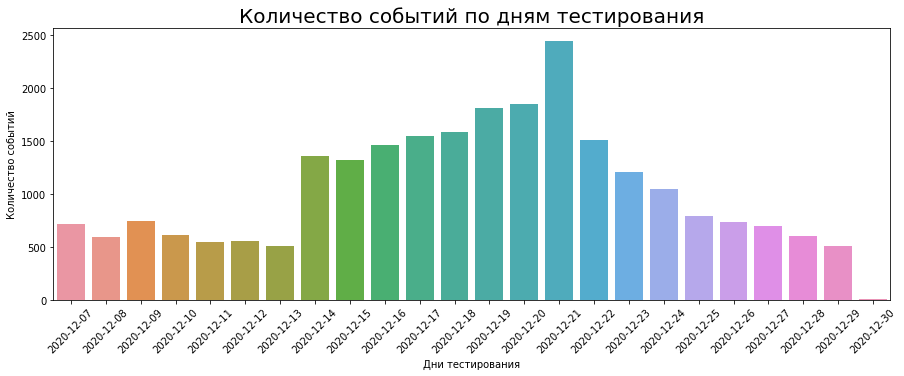

In [31]:
f, ax = plt.subplots(figsize = (15,5))
plt.title('Количество событий по дням тестирования',fontsize=20, weight='light')
g = sns.barplot(x= "event_date", y= "event_name", data= event_per_day)
plt.xticks(rotation=45)
plt.ylabel('Количество событий')
plt.xlabel('Дни тестирования')

У нас присутствуют данные с 7 по 30 декабря. Хотя сроки тестирования заявлены до 4 января 2021 года.

Мы видим, что число событий резко начало расти через неделю запуска тестирования. Причем самый пик событий получился на день, когда набор новых пользователей остановился. После роста на третью неделю тестирования количество событий стало падать. Возможно, это связзано с тем, что сначала рост количества событий был связан с заинтересованностью пользователей. После двух недель теста пользователи не очень оценили улучшения и количество событий стало падать. А, возможно, из-за начала рождественских и новогодних каникул люди стали меньше интересоваться данным магазином и его тематикой. Так как у нас пользователи из региона EU 25 декабря у них начинается Christmas&New Year Promo.

#### Посмотрим, сработал ли ожидаемый эффект от тестирования изменений, связанных с внедрением улучшенной рекомендательной системы.
Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%.

Посмотрим стало ли больше количество действий в день начала теста и через 2 недели.

In [32]:
pivotВ = ab_test_B.pivot_table(index='event_name',columns='event_date',values='user_id',aggfunc='count')
pivotВ['partВ'] = pivotВ['2020-12-21'] / pivotВ['2020-12-07']
pivotВ[['2020-12-07', '2020-12-21', 'partВ']]

event_date,2020-12-07,2020-12-21,partВ
event_name,,,
login,165.0,206.0,1.248485
product_cart,46.0,59.0,1.282609
product_page,108.0,111.0,1.027778
purchase,59.0,54.0,0.915254


- событие product_cart(просмотры корзины) увеличило свой показатель на 28%, это больше 10%, а значит эта метрика превзошла ожидания;
- событие product_page(просмотр карточек товаров) увеличило свой показатель всего на 2,7%. Это очень маленькое увеличение и эта метрика не оправдала ожиданий;
- событие purchase(покупка), является ключевым для бизнеса, так как с помощью покупки интернет-магазин получает прибыль. После тестирования новой рекомендательной системы покупки упали на 8,5%. Уже на этом моменте можно сказать, что новые внедрения не очень удачны.

In [33]:
pivotА = ab_test_A.pivot_table(index='event_name',columns='event_date',values='user_id',aggfunc='count')
pivotА['partА'] = pivotА['2020-12-21'] / pivotА['2020-12-07']
pivotА[['2020-12-07', '2020-12-21', 'partА']]

event_date,2020-12-07,2020-12-21,partА
event_name,,,
login,154,883,5.733766
product_cart,35,251,7.171429
product_page,96,580,6.041667
purchase,46,297,6.456522


- событие product_cart(просмотры корзины) увеличило свой показатель на 700%;
- событие product_page(просмотр карточек товаров) увеличило свой показатель на 600%;
- событие purchase(покупка) увеличило свой показатель на 600%;

То есть без новых внедрений ближе к рождественским каникулам, метрики вырастают просто в запредельное количество раз. Значит нововведения сдерживают этот рост. Плюс такие показатели еще могут быть из-за разницы в количестве пользователей в выборке.

#### Посмотрим какие еще А/В-тесты проводились.

In [34]:
ab_plus = users['ab_test'].value_counts().reset_index()
ab_plus

,index,ab_test
0,interface_eu_test,81927
1,recommender_system_test,24698


Еще одним тестом, который проводился был interface_eu_test. Посмотрим какие у него временные рамки, пересекались ли они с нашим тестом.

In [35]:
int_test = users.query('ab_test == "interface_eu_test"')

In [36]:
int_test['event_date'].min()

'2020-12-07'

In [37]:
int_test['event_date'].max()

'2020-12-30'

Мы видим, что у параллельного теста те же временные рамки, что и у нашего теста.

Проверим как пересекаются пользователи

In [38]:
match_int_test = int_test.groupby('user_id').agg({'event_name' : 'count'}).reset_index()
match_int_test.columns = ['user_id', 'count_user_int_test']
match_ab_test = ab_test.groupby('user_id').agg({'event_name' : 'count'}).reset_index()
match_ab_test.columns = ['user_id', 'count_user_ab_test']

In [39]:
match_int_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10850 entries, 0 to 10849
Data columns (total 2 columns):
user_id                10850 non-null object
count_user_int_test    10850 non-null int64
dtypes: int64(1), object(1)
memory usage: 169.7+ KB


In [40]:
match_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3675 entries, 0 to 3674
Data columns (total 2 columns):
user_id               3675 non-null object
count_user_ab_test    3675 non-null int64
dtypes: int64(1), object(1)
memory usage: 57.5+ KB


In [41]:
merge = match_int_test.merge(match_ab_test, on='user_id', how='outer')
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13638 entries, 0 to 13637
Data columns (total 3 columns):
user_id                13638 non-null object
count_user_int_test    10850 non-null float64
count_user_ab_test     3675 non-null float64
dtypes: float64(2), object(1)
memory usage: 426.2+ KB


Но при объединении таблиц мы определили, что пользователи из разных тестов не пересекаются. На результаты другой тест не влияет.

Учитывая одновременное проведение параллельного теста, а также проведение нашего теста во время маркетинговых событий, можно сказать, что тест проводился в некорректно выбранных условиях.

### [Шаг 3.](#run) Оценка результатов А/В-тестирования.  <a id="step3"></a>   
</div>  

#### Проверим, будет ли отличие долей  между выборками выборками A и В.

#### Зададим две гипотезы:
1. Нулевая гипотеза - конверсии выборки А и выборки В равны.
2. Альтернативная гипотеза - конверсии выборки А и выборки В не равны.

Возьмем функцию для Z-теста.

In [42]:
def z_func(main1, payment1, main2, payment2, alpha, test, event_name):
    aplha = alpha
    
    successes  = np.array([main1, main2])
    leads = np.array([payment1, payment2])
 
    # пропорция успехов в первой группе:
    p1 = successes [0]/leads[0]
    # пропорция успехов во второй группе:    
    p2 = successes [1]/leads[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes [0] + successes [1]) / (leads[0] + leads[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(abs(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1])))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print('p-значение для события "{}": '.format(event_name), p_value)
 
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между выборками", test, "есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать", test, "разными")

In [47]:
z_func(funnel['convA'].values[0], funnel['convA'].values[0], 
 funnel['convB'].values[0], funnel['convB'].values[0], 0.05, "конверсии выборки A и В", funnel['event_name'][0])

p-значение для события "login":  nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии выборки A и В разными


In [48]:
z_func(funnel['convA'].values[1], funnel['convA'].values[0], 
 funnel['convB'].values[1], funnel['convB'].values[0], 0.05, "конверсии выборки A и В", funnel['event_name'][1])

p-значение для события "product_page":  0.9027986320653953
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии выборки A и В разными


In [49]:
z_func(funnel['convA'].values[2], funnel['convA'].values[0], 
 funnel['convB'].values[2], funnel['convB'].values[0], 0.05, "конверсии выборки A и В", funnel['event_name'][2])

p-значение для события "purchase":  0.9995441587593894
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии выборки A и В разными


In [50]:
z_func(funnel['convA'].values[3], funnel['convA'].values[0], 
 funnel['convB'].values[3], funnel['convB'].values[0], 0.05, "конверсии выборки A и В", funnel['event_name'][3])

p-значение для события "product_cart":  0.8307041907802712
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии выборки A и В разными


Различия конверсии между группами отсутствует, значит нет оснований полагать, что тест прошел успешно. Конверсия не выросла и нет статистически значимой разницы между старым и новым функционалом, значит нет необходимости тратить ресурсы на внедрение новоых функций.

### [Шаг 4.](#run) Общие выводы. <a id="step4"></a>   
</div>  

- По разделению выборки составили соотношение 1 к 3;
- Всего уникальных пользователей в А/B-тесте было 3675, что оказалось меньше ожидаемых 6000;
- Доля пользователей, которая проходит на следующий этап выше в контрольной группе А, чем в экспериментальной группе В;
- В контрольной группе(7 событий) на одного пользователя приходится в среднем на 1,2 действия больше, чем в экспериментальной(5,8 событий); 

У нас присутствуют данные с 7 по 30 декабря. Хотя сроки тестирования заявлены до 4 января 2021 года.

Число событий резко начало расти через неделю запуска тестирования. Причем самый пик событий получился на день, когда набор новых пользователей остановился. После роста на третью неделю тестирования количество событий стало падать. Возможно, это связзано с тем, что сначала рост количества событий был связан с заинтересованностью пользователей. После двух недель теста пользователи не очень оценили улучшения и количество событий стало падать. А, возможно, из-за начала рождественских и новогодних каникул люди стали меньше интересоваться данным магазином и его тематикой. Так как у нас пользователи из региона EU 25 декабря у них начинается Christmas&New Year Promo.

По результатам А/B-тестирования:

Для экспериментальной выборки В:
- событие product_cart(просмотры корзины) увеличило свой показатель на 28%, это больше 10%, а значит эта метрика превзошла ожидания;
- событие product_page(просмотр карточек товаров) увеличило свой показатель всего на 2,7%. Это очень маленькое увеличение и эта метрика не оправдала ожиданий;
- событие purchase(покупка), является ключевым для бизнеса, так как с помощью покупки интернет-магазин получает прибыль. После тестирования новой рекомендательной системы покупки упали на 8,5%. Уже на этом моменте можно сказать, что новые внедрения не очень удачны.

Для контрольной выборки А:
- событие product_cart(просмотры корзины) увеличило свой показатель на 700%;
- событие product_page(просмотр карточек товаров) увеличило свой показатель на 600%;
- событие purchase(покупка) увеличило свой показатель на 600%;


То есть без новых внедрений ближе к рождественским каникулам, метрики вырастают просто в запредельное количество раз. Значит нововведения сдерживают этот рост. Плюс такие показатели еще могут быть из-за разницы в количестве пользователей в выборке.

Учитывая одновременное проведение параллельного теста, а также проведение нашего теста во время маркетинговых событий, можно сказать, что тест проводился в некорректно выбранных условиях.

Различия конверсии между группами отсутствует, значит нет оснований полагать, что тест прошел успешно. Конверсия не выросла и нет статистически значимой разницы между старым и новым функционалом, значит нет необходимости тратить ресурсы на внедрение новоых функций.